In [29]:
# 将当前文件夹下的 "打怪_test.csv" 进行数据拆分
# "打怪_test.csv" 的最后一列 labal 分离到 "打怪_test_label.csv"
# 同时 "打怪_test_label.csv" 中需要复制 "打怪_test.csv" 的第一列 时间
# 还有删除 "打怪_test.csv" 中的 label 列

import pandas as pd

df = pd.read_csv("test.csv")

# 分离 label 列和 absTime 列，保存到 "打怪_test_label.csv"
if 'label' in df.columns:
	df_label = df[['absTime', 'label']]
	df_label.to_csv("test_label.csv", index=False)
	# 删除原表中的 label 列
	df = df.drop(columns=['label'])
	df.to_csv("test1.csv", index=False)
else:
	print("列 'label' 不存在，无需拆分。")

列 'label' 不存在，无需拆分。


In [9]:
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
data_name = ['absTime', 
             'FPS',
             'AppCPU[%]',
             'CTemp[℃]',
             'GPU Counter:GPU General:% Busy',
             'GTemp[℃]', 
             'Power[mW]']
df_test = df_test[data_name]
df_train = df_train[data_name]
df_test.to_csv("test1.csv", index=False)
df_train.to_csv("train1.csv", index=False)

Cluster 0 平均 FPS: 59.83
Cluster 1 平均 FPS: 56.60

聚类与人工标签的重合度:
准确率: 0.5078

分类报告:
              precision    recall  f1-score   support

           0       0.73      0.49      0.58      1500
           1       0.31      0.56      0.40       609

    accuracy                           0.51      2109
   macro avg       0.52      0.52      0.49      2109
weighted avg       0.61      0.51      0.53      2109



正常(标签0)的预测准确率: 0.4873
异常(标签1)的预测准确率: 0.5583


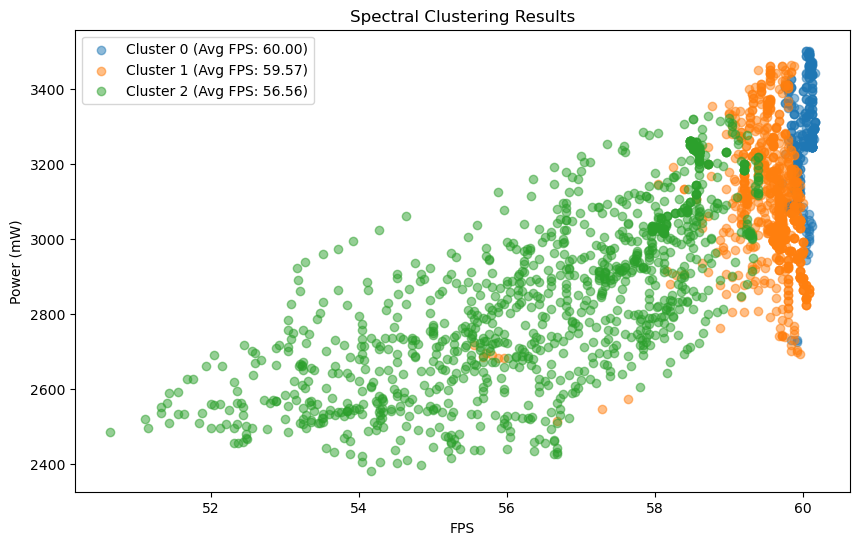

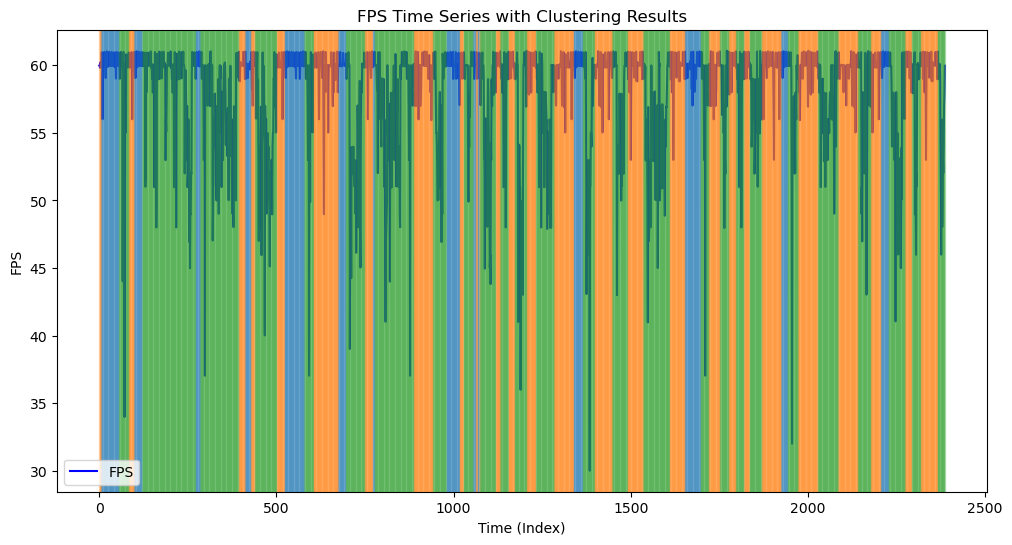

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.cluster import SpectralClustering
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df_test = pd.read_csv("test.csv")
df_label = pd.read_csv("test_label.csv")
fps_data = df_test['FPS'].values
human_labels = df_label['label'].values

# 构建频谱
window_size = 25
frequencies = []
for i in range(len(fps_data) - window_size + 1):  # 修改：步长改为1
    segment = fps_data[i:i + window_size]
    freq, power = welch(segment, nperseg=window_size)
    frequencies.append(power)

frequencies = np.array(frequencies)

# 谱聚类
n_clusters = 3
human_lable_mapping = {0:0, 1:0, 2:1}  # clasuter -> human label mapping
# n_clusters = 4
# human_lable_mapping = {0:0, 1:0, 2:0, 3:1}  # clasuter -> human label mapping

clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=535)
labels = clustering.fit_predict(frequencies)

# 根据聚类结果计算平均 FPS 并命名
cluster_names = {}
cluster_avg_fps = np.zeros(n_clusters)
for cluster in range(n_clusters):
    cluster_indices = np.where(labels == cluster)[0]
    avg_fps = np.mean([np.mean(fps_data[i:i + window_size]) for i in cluster_indices])  # 修改：使用窗口起始位置i
    cluster_names[cluster] = f"Cluster {cluster} (Avg FPS: {avg_fps:.2f})"
    cluster_avg_fps[cluster] = avg_fps

# 根据平均 FPS 对聚类结果进行排序
# 根据平均 FPS 对聚类结果进行排序（从高到低）
sorted_clusters = sorted(range(n_clusters), key=lambda x: cluster_avg_fps[x], reverse=True)

# 重新映射聚类标签
label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted_clusters)}
labels = np.array([label_mapping[label] for label in labels])

# 更新聚类名称和平均FPS
sorted_cluster_names = {}
sorted_cluster_avg_fps = np.zeros(n_clusters)
for new_idx, old_idx in enumerate(sorted_clusters):
    sorted_cluster_names[new_idx] = f"Cluster {new_idx} (Avg FPS: {cluster_avg_fps[old_idx]:.2f})"
    sorted_cluster_avg_fps[new_idx] = cluster_avg_fps[old_idx]

cluster_names = sorted_cluster_names
cluster_avg_fps = sorted_cluster_avg_fps



# 结果分析
# 计算聚类与human_labels的重合度
# 首先需要将窗口级别的聚类标签映射回原始时间序列
predicted_labels = np.zeros(len(fps_data))

# 将聚类结果映射到原始时间序列
for i in range(len(labels)):
    start_idx = i
    end_idx = i + window_size
    predicted_labels[start_idx:end_idx] = labels[i]

# 由于窗口重叠，取众数作为最终预测
final_predicted = np.zeros(len(fps_data))
for i in range(len(fps_data)):
    # 找到覆盖当前时间点的所有窗口
    covering_windows = []
    for j in range(max(0, i - window_size + 1), min(len(labels), i + 1)):
        if j + window_size > i:
            covering_windows.append(labels[j])
    
    if covering_windows:
        # 取众数
        final_predicted[i] = Counter(covering_windows).most_common(1)[0][0]

report = True
if report:



    mapped_predicted = [human_lable_mapping[int(label)] for label in final_predicted]
    # 确定聚类标签对应关系
    # 计算每个聚类对应的平均FPS
    cluster_0_fps = np.mean([fps_data[i] for i in range(len(fps_data)) if mapped_predicted[i] == 0])
    cluster_1_fps = np.mean([fps_data[i] for i in range(len(fps_data)) if mapped_predicted[i] == 1])

    print(f"Cluster 0 平均 FPS: {cluster_0_fps:.2f}")
    print(f"Cluster 1 平均 FPS: {cluster_1_fps:.2f}")

    # 需要从df_label中获取对应的标签
    human_labels_array = df_label['label'].values

    # 确保长度一致
    min_len = min(len(mapped_predicted), len(human_labels_array))
    mapped_predicted_trimmed = mapped_predicted[:min_len]
    human_labels_trimmed = human_labels_array[:min_len]

    accuracy = accuracy_score(human_labels_trimmed, mapped_predicted_trimmed)
    conf_matrix = confusion_matrix(human_labels_trimmed, mapped_predicted_trimmed)

    print(f"\n聚类与人工标签的重合度:")
    print(f"准确率: {accuracy:.4f}")
    # print(f"混淆矩阵:")
    # print(conf_matrix)
    print(f"\n分类报告:")
    print(classification_report(human_labels_trimmed, mapped_predicted_trimmed))

    # 计算每个类别的准确率
    print(f"\n")
    print(f"正常(标签0)的预测准确率: {conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1]):.4f}")
    print(f"异常(标签1)的预测准确率: {conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]):.4f}")


# 可视化聚类结果
plt.figure(figsize=(10, 6))
for cluster in range(n_clusters):
    cluster_indices = np.where(labels == cluster)[0]
    compute_fps = lambda i: fps_data[i:i + window_size].mean()
    compute_y = lambda i: df_test['Power[mW]'].iloc[i:i + window_size].mean()  # 修改：使用窗口起始位置i
    cluster_points = [(compute_fps(i), compute_y(i))for i in cluster_indices]
    cluster_points = np.array(cluster_points)
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=cluster_names[cluster],alpha=0.5)

plt.xlabel('FPS')
plt.ylabel('Power (mW)')
plt.title('Spectral Clustering Results')
plt.legend()
plt.savefig('spectral_clustering_results.png')

# 绘制 FPS 时序图并显示聚类结果
plt.figure(figsize=(12, 6))
plt.plot(fps_data, label='FPS', color='blue')

# 根据final_predicted添加聚类结果的着色
for i in range(len(final_predicted)):
    color = f'C{int(final_predicted[i])}'
    plt.axvline(x=i, color=color, alpha=0.3, linewidth=1)

# 添加图例
import matplotlib.patches as mpatches
legend_elements = [mpatches.Patch(color=f'C{cluster}', alpha=0.3, label=cluster_names[cluster]) 
                   for cluster in range(n_clusters)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Time (Index)')
plt.ylabel('FPS')
plt.title('FPS Time Series with Clustering Results')
plt.legend()
plt.savefig('fps_time_series_with_clustering.png')
